#Jigsaw Unintended Bias in Toxicity Classification

Detect toxicity across a diverse range of conversations.

https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/data

In [ ]:
from google.colab import drive
import keras

from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer  
from keras.preprocessing.sequence import pad_sequences
from keras import models
from keras import layers
from keras import optimizers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from nltk.corpus import wordnet
import unicodedata
import html
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Embedding


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:

drive.mount("/content/colab/")

Drive already mounted at /content/colab/; to attempt to forcibly remount, call drive.mount("/content/colab/", force_remount=True).


In [ ]:
%cd "colab/MyDrive/Assignment7"

/content/colab/MyDrive/Assignment7


In [ ]:
# # Install Kaggle API
# !pip install --quiet kaggle

# import os
# if '.kaggle' not in os.listdir('/root'):
#     !mkdir ~/.kaggle

# # !mkdir -p ~/.kaggle
# !cp /content/kaggle.json ~/.kaggle/

# !chmod 600 /root/.kaggle/kaggle.json

# # Get the dataset
# !kaggle competitions download -c jigsaw-unintended-bias-in-toxicity-classification

In [ ]:
!ls

all_data.csv.zip
glove.6B.100d.txt
glove.6B.50d.txt
identity_individual_annotations.csv.zip
sample_submission.csv.zip
test.csv.zip
test_private_expanded.csv.zip
test_public_expanded.csv.zip
toxicity_individual_annotations.csv.zip
train_clean_.csv
train_clean.csv
train.csv.zip


In [ ]:

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, HashingVectorizer, TfidfTransformer
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from keras import optimizers
import re
import string
import nltk


# Frame the problem

This is a** Sequence Classification Problem**

Can you help detect toxic comments ― and minimize unintended model bias? That's your challenge in this competition.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both part of Alphabet), builds technology to protect voices in conversation. A main area of focus is machine learning models that can identify toxicity in online conversations, where toxicity is defined as anything rude, disrespectful or otherwise likely to make someone leave a discussion.

Jigsaw sponsored this effort and extended annotation of this data by **human raters** for various toxic conversational attributes.

The model I'll  be implementing is LSTM/GRU.

This  implies   less work   onn  text cleaning, for  instance, there's  no need to  stem  words. However, I'll still  need  to   remove punctuation from words, and convert all characters to lowercase.

- **Metric**: We combine the **overall AUC** with the generalized mean of the **Bias AUCs** to calculate the final model score:

# Evaluation metric in brief
## 1.AUC
Receiver operating characteristic (ROC) graphs are useful tools to select models for 
classification based on their performance with respect to the FPR(False PositiveRate) and TPR(True  Positive  Rate), which 
are computed by shifting the ***decision threshold of the classifier***. The diagonal of 
the ROC graph can be interpreted as random guessing, and classification models that 
fall below the diagonal are considered as worse than random guessing. A perfect 
classifier would fall into the top-left corner of the graph with a TPR of 1 and an FPR 
of 0. Based on the ROC curve, we can then compute the so-called ROC area under 
the curve (ROC AUC) to characterize the performance of a classification model.

 A per‐
fect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will
have a ROC AUC equal to 0.5.

Reporting the performance of a classifier as the ROC AUC can yield further insights 
into a classifier's performance with respect to **imbalanced samples**,which is our case with the toxic dataset.

## 2.Bias AUC
In Conversation AI's recent paper *Nuanced Metrics for Measuring Unintended Bias with Real Data in Text Classification*:   "Most metrics for unintended bias rely on dividing the test dataup by identity or demographic based subgroups and computing  metrics for each group. For our metrics, we also divide data bysubgroup. However, instead of calculating metrics on the subgroupdata exclusively, **our metrics compare the subgroup to the rest ofthe data, which we call the “background” data"**:

a.Subgroup AUC: Here, we restrict the data set to only the examples that mention the specific identity subgroup. A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.

b.BPSN  AUC: Here, we restrict the test set to the non-toxic examples that mention the identity and the toxic examples that do not. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.

c.BNSP AUC: Here, we restrict the test set to the toxic examples that mention the identity and the non-toxic examples that do not. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.

# Get the data

In [ ]:

train_data =pd.read_csv("train.csv.zip")

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 45 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [ ]:
test=pd.read_csv("test.csv.zip")

In [ ]:
test

,id,comment_text
0,7097320,[ Integrity means that you pay your debts.]\n\...
1,7097321,This is malfeasance by the Administrator and t...
2,7097322,@Rmiller101 - Spoken like a true elitist. But ...
3,7097323,"Paul: Thank you for your kind words. I do, in..."
4,7097324,Sorry you missed high school. Eisenhower sent ...
...,...,...
97315,7194635,He should lose his job for promoting mis-infor...
97316,7194636,"""Thinning project is meant to lower fire dange..."
97317,7194637,I hope you millennials are happy that you put ...
97318,7194638,I'm thinking Kellyanne Conway (a.k.a. The Trum...



**Toxicity lables:**
    severe_toxicity

    obscene

    threat

    insult

    identity_attack

    sexual_explicit
    


---



In addition to the labels described above, the dataset also provides metadata from Jigsaw's annotation: **toxicity_annotator_count** and identity_annotator_count, and metadata from Civil Comments: created_date, publication_id, parent_id, article_id, rating, funny, wow, sad, likes, disagree. Civil Comments' label rating is the civility rating Civil Comments users gave the comment.

In [ ]:
train_data.head()

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.0,0.000000,0.00000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.0,0.021277,0.87234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.0,4,47


In [ ]:
train_data["toxicity_annotator_count"].value_counts()

4       1185412
10       262216
6        195839
5         76341
80         8537
         ...   
2283          1
1259          1
1261          1
242           1
3071          1
Name: toxicity_annotator_count, Length: 775, dtype: int64

In [ ]:
train_data["rating"].value_counts()

approved    1684758
rejected     120116
Name: rating, dtype: int64

In [ ]:
train_data[train_data["rating"] == "approved"]["comment_text"]

8          The ranchers seem motivated by mostly by greed...
9          It was a great show. Not a combo I'd of expect...
10                                   Wow, that sounds great.
11         This is a great story. Man. I wonder if the pe...
12            This seems like a step in the right direction.
                                 ...                        
1804869    Maybe the tax on "things" would be collected w...
1804870    What do you call people who STILL think the di...
1804871    thank you ,,,right or wrong,,, i am following ...
1804872    Anyone who is quoted as having the following e...
1804873    Students defined as EBD are legally just as di...
Name: comment_text, Length: 1684758, dtype: object

In [ ]:
train_data[train_data["rating"] == "approved"]["comment_text"][11]

'This is a great story. Man. I wonder if the person who yelled "shut the fuck up!" at him ever heard it.'

# EDA
Understand each column, visualize distributions

visualize target variable

In [ ]:
train_data["target_label"]=train_data["target"].apply(lambda x: 1 if x >0.5 else 0)

In [ ]:
train_data.head(10)

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target_label
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0
2,59852,0.000000,This is such an urgent design problem; kudos t...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:45.222647+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0
3,59855,0.000000,Is this something I'll be able to install on m...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:47.601894+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0
4,59856,0.893617,haha you guys are a bunch of losers.,0.021277,0.000000,0.021277,0.872340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2015-09-29 10:50:48.488476+00,2,NaN,2006,rejected,0,0,0,1,0,0.000000,4,47,1
5,59859,0.666667,ur a sh*tty comment.,0.047619,0.638095,0.000000,0.333333,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:50.865549+00,2,NaN,2006,rejected,0,0,0,0,0,0.009524,0,105,1
6,59861,0.457627,hahahahahahahahhha suck it.,0.050847,0.305085,0.000000,0.254237,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:52.451277+00,2,NaN,2006,rejected,0,0,0,0,0,0.220339,0,59,0
7,59863,0.000000,FFFFUUUUUUUUUUUUUUU,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:54.055221+00,2,NaN,2006,rejected,0,0,0,0,0,0.000000,0,4,0
8,239575,0.000000,The ranchers seem motivated by mostly by greed...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:01:05.156229+00,6,NaN,26662,approved,0,0,0,0,0,0.000000,0,4,0
9,239576,0.000000,It was a great show. Not a combo I'd of expect...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2016-01-13 18:11:21.570460+00,6,239522.0,26650,approved,0,0,0,1,0,0.000000,0,4,0


In [ ]:
train_data.target_label.value_counts()/train_data.shape[0]*100

0    94.102746
1     5.897254
Name: target_label, dtype: float64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


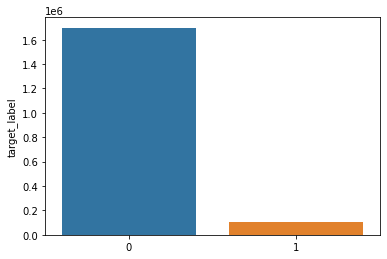

In [ ]:
import  seaborn  as sns

x = train_data.target_label.value_counts()
sns.barplot(x.index, x)
plt.gca().set_label("samples")

Obviously,94.10% are non-toxic,   this creates a challenge in developing a non-biased algorithm

In [ ]:
train_data["comment_text"][14]

"This story gets more ridiculous by the hour! And, I love that people are sending these guys dildos in the mail now. But… if they really think there's a happy ending in this for any of them, I think they're even more deluded than all of the jokes about them assume."

In [ ]:
train_data[["comment_text", "target"]].head()

,comment_text,target
0,"This is so cool. It's like, 'would you want yo...",0.000000
1,Thank you!! This would make my life a lot less...,0.000000
2,This is such an urgent design problem; kudos t...,0.000000
3,Is this something I'll be able to install on m...,0.000000
4,haha you guys are a bunch of losers.,0.893617


In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 46 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [ ]:
# train_data[train_data["target_label"]==1]["severe_toxicity"].describe()

In [ ]:
train_data["jewish"].value_counts()

0.000000    394225
1.000000      3974
0.100000      1603
0.800000       856
0.833333       800
             ...  
0.001935         1
0.000783         1
0.006156         1
0.003271         1
0.968730         1
Name: jewish, Length: 120, dtype: int64

In [ ]:
train_data["comment_text"][197]

'Read the whole article.... nowhere does it mention Vera Katz...... woman mayor of portland.....\n\nThis article says this sarah lady would be first\n\nVera used to sign up with me when i was a kid doing run for the arts program and my grandma worked at city hall.'

In [ ]:
train_data[train_data["female"]>0]

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target_label
34,239612,0.830769,This bitch is nuts. Who would read a book by a...,0.107692,0.661538,0.338462,0.830769,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2016-01-13 21:08:08.861688+00,6,NaN,26674,rejected,0,0,0,0,0,0.061538,4,65,1
191,239907,0.300000,"Thank you for this article, all I need to know...",0.000000,0.000000,0.300000,0.200000,0.1,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,1.0,2016-01-19 23:58:10.704243+00,6,NaN,32123,approved,0,0,0,2,0,0.000000,4,10,0
197,239917,0.000000,Read the whole article.... nowhere does it men...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2016-01-20 04:13:35.371491+00,6,NaN,32123,approved,0,0,0,0,0,0.000000,6,4,0
200,239921,0.200000,To meet these people with threats of violence ...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.600000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2016-01-20 06:09:42.501972+00,6,NaN,26645,approved,0,0,0,0,0,0.000000,10,10,0
221,239980,0.000000,The article says Sarah would be the first fema...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.800000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.000000,0.0,0.0,2016-01-20 22:06:01.282648+00,6,239917.0,32123,approved,0,0,0,1,0,0.000000,10,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804815,6333827,0.000000,Judging by the hostility toward Trudeau's care...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.300000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2017-11-11 00:31:52.776412+00,54,NaN,399437,approved,0,0,0,0,0,0.000000,10,4,0
1804839,6333872,0.200000,I don't know that abortion played much of a pa...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2017-11-11 00:41:07.880299+00,53,6332177.0,399276,approved,0,0,0,0,0,0.000000,4,5,0
1804841,6333875,0.166667,"""It doesn't matter when it's erected and for w...",0.000000,0.000000,0.000000,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166667,0.0,0.0,2017-11-11 00:40:49.412201+00,13,6333686.0,398655,approved,0,0,0,0,0,0.000000,6,6,0
1804848,6333897,0.000000,Women's rights? Last I checked women were jus...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,2017-11-11 00:45:11.003701+00,53,6329946.0,399276,approved,0,0,0,0,0,0.000000,4,4,0


 Civil Comments' label rating is the civility rating Civil Comments users gave the comment. rejected means the comment is not civilaized(26674),while approved means it's   civilized(a comment could  be both toxic and civilized)

In [ ]:
train_data[train_data["rating"]=="approved"]["target_label"].value_counts()

0    1604366
1      80392
Name: target_label, dtype: int64

In [ ]:
train_data[train_data["rating"]=="rejected"]["target_label"].value_counts()

0    94070
1    26046
Name: target_label, dtype: int64

In [ ]:
# import  seaborn  as sns

# x = train_data.target_label
# sns.barplot(x,train_data["rating"])
# plt.gca().set_label("samples")

In [ ]:
train_data["obscene"].describe()

count    1.804874e+06
mean     1.387721e-02
std      6.460419e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: obscene, dtype: float64

Plot histogram of sever_toxicity

severe_toxicity; from 0 to 1

Plot disitribution of continous variables in both toxic and non-toxic comments

In [ ]:
# FEATURES = ['severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat',
#                 'black', 'female', 'homosexual_gay_or_lesbian', 'jewish']
# toxic_comments = train_data['target_label'] == 1

# fig, axes = plt.subplots(ncols=2, nrows=len(FEATURES), figsize=(20, 50), dpi=100)

# for i, feature in enumerate(FEATURES):
#     sns.distplot(train_data.loc[~toxic_comments][feature], label='Not toxic', ax=axes[i][0], color='green')
#     sns.distplot(train_data.loc[toxic_comments][feature], label='toxic', ax=axes[i][0], color='red')

#    # sns.distplot(train_data[feature], label='Training', ax=axes[i][1])
#    # sns.distplot(train_data[feature], label='Test', ax=axes[i][1])
    
#     for j in range(1):
#         axes[i][j].set_xlabel('')
#         axes[i][j].tick_params(axis='x', labelsize=12)
#         axes[i][j].tick_params(axis='y', labelsize=12)
#         axes[i][j].legend()
    
#     axes[i][0].set_title(f'{feature} Target Distribution in Training Set', fontsize=13)
#   #  axes[i][1].set_title(f'{feature} Training & Test Set Distribution', fontsize=13)

# plt.show()

It's clear that the "insult" column is a significant feature in classifying the target, sinnce the distribution center for the  toxic comments is centered aroun 0.6, while for non-toxic comments, it's around 0

We  can limit the y scale  to visualize small numbers.

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1804874 entries, 0 to 1804873
Data columns (total 46 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   id                                   int64  
 1   target                               float64
 2   comment_text                         object 
 3   severe_toxicity                      float64
 4   obscene                              float64
 5   identity_attack                      float64
 6   insult                               float64
 7   threat                               float64
 8   asian                                float64
 9   atheist                              float64
 10  bisexual                             float64
 11  black                                float64
 12  buddhist                             float64
 13  christian                            float64
 14  female                               float64
 15  heterosexual                    

In [ ]:
train_data["obscene"].describe()

count    1.804874e+06
mean     1.387721e-02
std      6.460419e-02
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.000000e+00
Name: obscene, dtype: float64

# Selecting  variabbles

Since I'll be using deep learning (LSTM and GRU), I don't need all of these hand-crafted features: the model learns them by itself.
Hence, the following analysis will be focused on the  comment_text only.

In [ ]:
train_comments = train_data[["comment_text", "target", "target_label"]]

In [ ]:
test_data=test[["comment_text"]]

# EDA>>   comments

A good practice is to **visualize train and test set to know if they come from the same distribution.**

# Data Cleaning

## Duplicates
### dataset level

In [ ]:
pd.set_option('display.max_rows', 5)

In [ ]:
train_comments["comment_text"][288570]

'http://www.catholicleague.org/when-the-pope-tried-to-kill-hitler/'

In [ ]:
train_comments[train_comments.duplicated(keep=False)].reset_index()

,index,comment_text,target,target_label
0,35,Awesome!,0.0,0
1,140,Me too!,0.0,0
...,...,...,...,...
26355,1804654,Exactly.,0.0,0
26356,1804833,Yawn 😴,0.0,0


Ex. 1804833 contains emojis>> remove them

In [ ]:
train_comments["comment_text"][453124]

'Yawn ...'

In [ ]:
train_comments.drop_duplicates(keep = "first", inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_comments[train_comments.duplicated(keep=False)].reset_index()

,index,comment_text,target,target_label


In [ ]:
train_data

,id,target,comment_text,severe_toxicity,obscene,identity_attack,insult,threat,asian,atheist,bisexual,black,buddhist,christian,female,heterosexual,hindu,homosexual_gay_or_lesbian,intellectual_or_learning_disability,jewish,latino,male,muslim,other_disability,other_gender,other_race_or_ethnicity,other_religion,other_sexual_orientation,physical_disability,psychiatric_or_mental_illness,transgender,white,created_date,publication_id,parent_id,article_id,rating,funny,wow,sad,likes,disagree,sexual_explicit,identity_annotator_count,toxicity_annotator_count,target_label
0,59848,0.000000,"This is so cool. It's like, 'would you want yo...",0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:41.987077+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,0
1,59849,0.000000,Thank you!! This would make my life a lot less...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2015-09-29 10:50:42.870083+00,2,NaN,2006,rejected,0,0,0,0,0,0.0,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804872,6334009,0.621212,Anyone who is quoted as having the following e...,0.030303,0.030303,0.045455,0.621212,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 01:01:10.153692+00,13,6333833.0,399519,approved,0,0,0,0,0,0.0,0,66,1
1804873,6334010,0.000000,Students defined as EBD are legally just as di...,0.000000,0.000000,0.000000,0.000000,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-11-11 01:01:10.822969+00,13,6333965.0,399318,approved,0,0,0,0,0,0.0,0,4,0


In [ ]:
train_comments

,comment_text,target,target_label
0,"This is so cool. It's like, 'would you want yo...",0.000000,0
1,Thank you!! This would make my life a lot less...,0.000000,0
...,...,...,...
1804872,Anyone who is quoted as having the following e...,0.621212,1
1804873,Students defined as EBD are legally just as di...,0.000000,0


### dataset  without target;   __duplicated   ratings__

In [ ]:
train_comments[train_comments[["comment_text","target_label"]].duplicated()]

,comment_text,target,target_label
84,"Tuesday Jan. 13, members of \nthis socalled 'm...",0.500000,0
6955,"Wait, fer real? That went to court?! And he WO...",0.614286,1
...,...,...,...
1804323,Congrats on being a criminal-cop enabler. You'...,0.578125,1
1804371,Congrats on being a criminal-cop enabler. You'...,0.593750,1


In [ ]:
train_comments.drop_duplicates(subset=["comment_text","target_label"],keep="first",inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Clearly,  some comments are rated with different percentages by different users. This   is useless since eventually, we'll predict either 1 or 0.

Also,  we  shouldnnn't remove links since 288570 only contains a link, but we can remove the  "html" word from the  dictionary

In [ ]:
train_comments

,comment_text,target,target_label
0,"This is so cool. It's like, 'would you want yo...",0.000000,0
1,Thank you!! This would make my life a lot less...,0.000000,0
...,...,...,...
1804872,Anyone who is quoted as having the following e...,0.621212,1
1804873,Students defined as EBD are legally just as di...,0.000000,0


 #### __ Mislabeled/confusing Samples?__

are there any examples that are labeled differently(both 0 and 1) by different users?

In [ ]:
#df_mislabeled = df_train.groupby(['text']).nunique().sort_values(by='target', ascending=False)
train_grouped_by_text=train_comments.groupby(["comment_text"]).nunique().sort_values(by="target_label",ascending =False)
##for  each  unnnique  commennt,  sort target_label 
train_mislabeled = train_grouped_by_text[train_grouped_by_text["target_label"]>1]["target_label"]
len(train_mislabeled.index.tolist())

466

In [ ]:
type(train_mislabeled.index.tolist())

list

In [ ]:

train_comments[train_comments["comment_text"]==train_mislabeled.index.tolist()[0]]["comment_text"]

968978    Are you saying that everyone who voted for Tru...
970177    Are you saying that everyone who voted for Tru...
Name: comment_text, dtype: object

In [ ]:
train_comments.drop(train_comments[train_comments["comment_text"]==train_mislabeled.index.tolist()[1]].index,axis=0,inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Since his portion  represents  0.026% of the data,Dropping  these columns would be much more conveniennt  than  manual  correction(which  would be a wated effort).

In [ ]:
#visually inspecting#
for i in range (0,466):
  train_comments.drop(train_comments[train_comments["comment_text"]==train_mislabeled.index.tolist()[i]].index, axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


validate

In [ ]:
train_comments

,comment_text,target,target_label
0,"This is so cool. It's like, 'would you want yo...",0.000000,0
1,Thank you!! This would make my life a lot less...,0.000000,0
...,...,...,...
1804872,Anyone who is quoted as having the following e...,0.621212,1
1804873,Students defined as EBD are legally just as di...,0.000000,0


## Checknull values

In [ ]:
train_comments.isnull().sum()/ train_comments.shape[0]*100

comment_text    0.0
target          0.0
target_label    0.0
dtype: float64

In [ ]:
test_data.isnull().sum()

comment_text    0
dtype: int64

great!

# Prepare the data for Machine Learning algorithms

## Text Cleaning and preprocessing
In this assignmet,I'll use pre-trained embeddings(Glove) along with an LSTM.

The benefit of word embeddings is that
they encode each word into a dense vector that captures something about its relative meaning within the training text. 

This means that variations of words like case, spelling, punctuation,
and so on will automatically be learned to be similar in the embedding space. 

In turn, this can mean that the amount of cleaning required from your text may be less and perhaps quite diffeerent to classical text cleaning. 

For example, __it may no-longer make sense to stem words or
remove punctuation for contractions.__

Tomas Mikolov is one of the developers of Word2Vec, a popular word embedding method. He suggests only very minimal text cleaning is required when learning a word embedding model. Below is his response when pressed with the question about how to best prepare text data for Word2Vec.

_There is no universal answer. It all depends on what you plan to use the vectors
for. In my experience, it is usually good to disconnect (or __
- remove) punctuation from
words,
-  and sometimes also convert all characters to lowercase. 
- One can also replace
all numbers (possibly greater than some constant) with some single token such as .__

All these pre-processing steps aim to reduce the vocabulary size wit hout removing
any important content (which in some cases may not be true when you lowercase
certain words, ie. `Bush' is dierent than `bush', while `Another' has usually the
same sense as `another'). The smaller the vocabulary is, the lower is the memory
complexity, and the more robustly are the parameters for the words estimated. You
also have to pre-process the test data in the same way.

In [ ]:
train_comments[train_comments.duplicated(keep=False)].reset_index()

,index,comment_text,target,target_label


In [ ]:
train_comments["comment_text"].head(40)

0     This is so cool. It's like, 'would you want yo...
1     Thank you!! This would make my life a lot less...
                            ...                        
38    Interesting concept.\n\nHow does Civil Comment...
39    Pity the menu lost so much vegan food! The Mas...
Name: comment_text, Length: 40, dtype: object

In [ ]:
train_comments["comment_text"][180]

'defending genocide is really racist. anyway, your analogy is a poor analogy. north america is not analogous to a private residence. but, your typical of comments frequently used by the reverse racists. And, particularly people who seek to immigrant to the USA, illegally. they often know nothing of american history, except for propaganda that justifies their personal agenda'

In [ ]:

def remove_special_chars(text):
    re1 = re.compile(r'  +')
    x1 = text.lower().replace('#39;', "'").replace('amp;', '&').replace('#146;', "'").replace(
        'nbsp;', ' ').replace('#36;', '$').replace('\\n', "\n").replace('quot;', "'").replace(
        '<br />', "\n").replace('\\"', '"').replace('<unk>', 'u_n').replace(' @.@ ', '.').replace(
        ' @-@ ', '-').replace('\\', ' \\ ')
    return re1.sub(' ', html.unescape(x1))

def remove_html(text):
    html=re.compile(r"<.*?>")
    return  html.sub(r'',  text)
   # This should happen before all other preprocessing steps,
   # as we will see in the full pipeline, since it will help sentence and words tokenization for example, and will reduce vocab. 
   

def remove_non_ascii(text):
    """Remove non-ASCII characters from list of tokenized words"""
    return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')


def remove_punctuation(text):
    """Remove punctuation from list of tokenized words"""
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


#7599:#Earthquake
#other   examples: earthquake, EARTHQUAKE

def to_lowercase(text):
    return text.lower()


def replace_numbers(text): #???
    """Replace all interger occurrences in list of tokenized words with textual representation"""
    return re.sub(r'\d+', '', text)


def remove_whitespaces(text):
    return text.strip

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def text2words(text):
  return word_tokenize(text)

def clean_text( text):
    text = remove_special_chars(text)
    text=remove_html(text)
    ##text=remove_urls(text)
    text = remove_non_ascii(text)
    text = remove_punctuation(text)
    text = to_lowercase(text)
    

   ## text = replace_numbers(text)
    words = text2words(text)
    #REMOVE STOPWORDS?
  ##  words = remove_stopwords(words, stop_words)
    ##words = stem_words(words)# Either stem ovocar lemmatize
    ##words = lemmatize_words(words)
    ##words = lemmatize_verbs(words)

    return ' '.join(words)

In [ ]:
clean_text(train_comments["comment_text"][0])

'this is so cool its like would you want your mother to read this really great idea well done'

**nnnot  sure  yet if I should replace numbers??? will this affect the LSTM??** couldn't find any exampleswithumers

In [ ]:
train_comments["comment_text"]=train_comments["comment_text"].apply(lambda x:clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_data["comment_text"]=test_data["comment_text"].apply(lambda x:clean_text(x))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
test_data

,comment_text
0,integrity means that you pay your debts does t...
1,this is malfeasance by the administrator and t...
...,...
97318,im thinking kellyanne conway aka the trump whi...
97319,i still cant figure why a pizza in ak cost mor...


In [ ]:
!ls

all_data.csv.zip
glove.6B.100d.txt
glove.6B.50d.txt
identity_individual_annotations.csv.zip
sample_submission.csv.zip
test.csv.zip
test_private_expanded.csv.zip
test_public_expanded.csv.zip
toxicity_individual_annotations.csv.zip
train_clean_.csv
train_clean.csv
train.csv.zip


Check nulls after text cleaning

In [ ]:
train_comments[train_comments["comment_text"].isnull()]

,comment_text,target,target_label


In [ ]:
train_data["comment_text"][316]

';)'

In [ ]:
train_comments.dropna(axis=0, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
train_comments.isnull().sum()/ train_comments.shape[0]*100

comment_text    0.0
target          0.0
target_label    0.0
dtype: float64

In [ ]:
#train_comments.to_csv("train_clean_.csv")

In [ ]:
test_data.to_csv("test_clean_.csv")

In [ ]:
test_data=pd.read_csv("test_clean_.csv")

Check duplicates after text cleaning

In [ ]:
train_comments=pd.read_csv("train_clean_.csv")

In [ ]:
train_comments.head()

,Unnamed: 0,Unnamed: 0.1,comment_text,target,target_label
0,0,0,this is so cool its like would you want your m...,0.000000,0
1,1,1,thank you this would make my life a lot less a...,0.000000,0
2,2,2,this is such an urgent design problem kudos to...,0.000000,0
3,3,3,is this something ill be able to install on my...,0.000000,0
4,4,4,haha you guys are a bunch of losers,0.893617,1


In [ ]:
train_comments[train_comments.duplicated(keep=False)].reset_index()

,index,Unnamed: 0,Unnamed: 0.1,comment_text,target,target_label


In [ ]:
train_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1780269 entries, 0 to 1780268
Data columns (total 5 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Unnamed: 0    int64  
 1   Unnamed: 0.1  int64  
 2   comment_text  object 
 3   target        float64
 4   target_label  int64  
dtypes: float64(1), int64(3), object(1)
memory usage: 67.9+ MB


## Wordcloud

In [ ]:
def create_corpus_df(tweet, target):
    corpus=[]
    
    for x in train_comments[train_comments['target_label']==target]['comment_text'].str.split():
   #     print(x)
        for i in x:
            corpus.append(i)
    return corpus

In [ ]:
train_comments['target_label']

0          0
1          0
          ..
1780267    1
1780268    0
Name: target_label, Length: 1780269, dtype: int64

Toxic

In [ ]:


corpus_toxic=create_corpus_df(train_comments,1)
len(corpus_toxic)

4627535

In [ ]:
corpus_toxic[:10]

['haha', 'you', 'guys', 'are', 'a', 'bunch', 'of', 'losers', 'ur', 'a']

not-toxic

In [ ]:
corpus_not_toxic=create_corpus_df(train_comments,0)

In [ ]:
len(corpus_not_toxic)

86863006

In [ ]:
corpus_not_toxic[:10]

['this', 'is', 'so', 'cool', 'its', 'like', 'would', 'you', 'want', 'your']

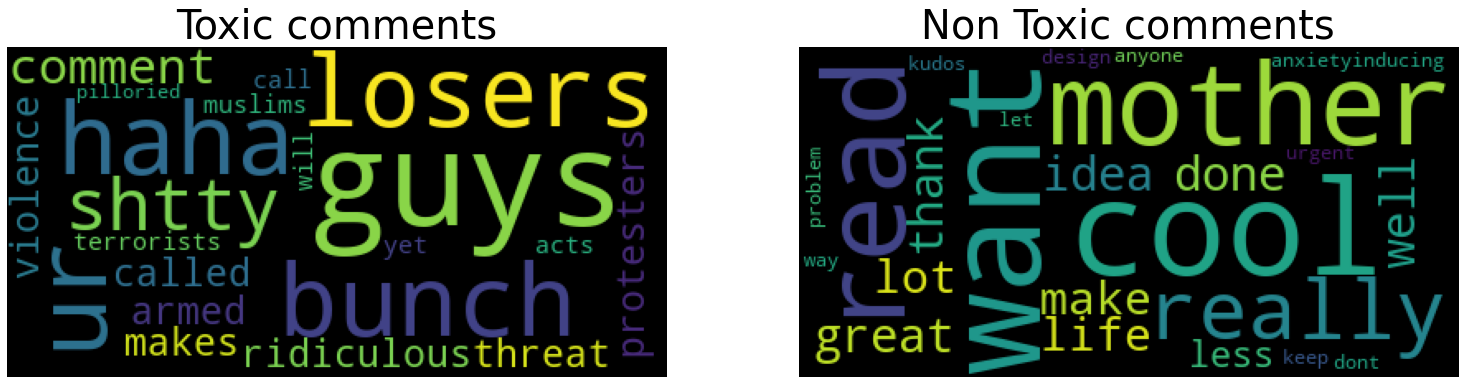

In [ ]:


from wordcloud import WordCloud
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[26, 8])
wordcloud1 = WordCloud( background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_toxic[:50]))
ax1.imshow(wordcloud1)
ax1.axis('off')
ax1.set_title('Toxic comments',fontsize=40);

wordcloud2 = WordCloud(background_color='black',
                          max_font_size = 80
                         ).generate(" ".join(corpus_not_toxic[:50]))
ax2.imshow(wordcloud2)
ax2.axis('off')
ax2.set_title('Non Toxic comments',fontsize=40);



##Load pre-trained word embeddings(glove)

## glove embeddings brief

In glove,a word embedding can be learned as part of a deep learning model.

https://keras.io/examples/nlp/pretrained_word_embeddings/

Let's download pre-trained GloVe embeddings (a 822M zip file).

You'll need to run the following commands:

In [ ]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
# !unzip -q glove.6B.zip
#only once

The archive contains text-encoded vectors of various sizes: 50-dimensional, 100-dimensional, 200-dimensional, 300-dimensional. We'll use the 100D ones,since it  produced good results in other kernels on the same problem.

Let's make a dict mapping words (strings) to their NumPy vector representation:

In [ ]:
path_to_glove_file="glove.6B.100d.txt"
embeddings_index = {}
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        #embeddings_index maps each word to its 100D embeddings
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
x=train_comments["comment_text"].tolist()
y=train_comments["target_label"].values

In [ ]:
x_test=test_data["comment_text"].tolist()

In [ ]:
train_comments.drop(["Unnamed: 0","Unnamed: 0.1"],axis=1,inplace=True)

In [ ]:
train_comments.head()

,comment_text,target,target_label
0,this is so cool its like would you want your m...,0.000000,0
1,thank you this would make my life a lot less a...,0.000000,0
2,this is such an urgent design problem kudos to...,0.000000,0
3,is this something ill be able to install on my...,0.000000,0
4,haha you guys are a bunch of losers,0.893617,1


## Tokenizing text

In [ ]:

max_tokens=10000

tok=Tokenizer(num_words=max_tokens,oov_token="UNK")
#tok.fit_on_texts(list(x) + list(x_test))
tok.fit_on_texts(x)
#forTrain Only

In [ ]:
# tok_test=Tokenizer(num_words=max_tokens,oov_token="UNK")
# tok_test.fit_on_texts(x_test)

In [ ]:
tok

In [ ]:
x=tok.texts_to_sequences(x)

In [ ]:
x_test=tok.texts_to_sequences(x_test)

In [ ]:
x_test[0]

[1977, 334, 9, 11, 133, 35, 6781, 105, 19, 1285, 3, 152, 59, 116]

In [ ]:
len(x[5])

4

In [ ]:
del   train_comments

In [ ]:

del  train_data


In [ ]:
del test_data

In [ ]:
a

In [ ]:
max_len=100
#reduced from 220 to 100 to solve the crashing RAM problem.
# we want the length of this list is a constant -> MAX_LEN
# if the list is longer, then we cut/trim it 
# if shorter, then we add/pad it with 0's at the beginning
x=pad_sequences(x,maxlen=max_len)

In [ ]:
x_test=pad_sequences(x_test,maxlen=max_len)

In [ ]:
#x_test=pad_sequences(x_test,maxlen=max_len)

## split data

In [ ]:

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.3, random_state=42)

Now, let's prepare a corresponding embedding matrix that we can use in a Keras Embedding layer. It's a simple NumPy matrix where entry at index i is the pre-trained vector for the word of index i in our vectorizer's vocabulary.

## Preparing the embedding matrix

In [ ]:
num_tokens = len(tok.word_index) + 2
embedding_dim = 100
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tok.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))


Converted 124742 words (500318 misses)


Next, we load the pre-trained word embeddings matrix into an Embedding layer.

Note that we set trainable=False so as to keep the embeddings fixed (we don't want to update them during training).

In [ ]:
from tensorflow.keras.layers import Embedding

embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


# Modeling

## LSTM

In [ ]:
model=models.Sequential()
model.add(embedding_layer)
model.add(layers.LSTM(128))
model.add(layers.Dense(1,activation="sigmoid"))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         62506200  
_________________________________________________________________
lstm (LSTM)                  (None, 128)               117248    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 62,623,577
Trainable params: 117,377
Non-trainable params: 62,506,200
_________________________________________________________________


In [ ]:
model.compile(loss="binary_crossentropy",optimizer=optimizers.Adam())
#we can't use accuracy here cuz  classes are imbalanced

In [ ]:
x_train[0]

In [ ]:
# x_train=np.array(x_train)
# x_val=np.array(x_val)
# y_train=np.array(y_train)
# y_val=np.array(y_val)

In [ ]:
x_val=np.array(x_val)

In [ ]:
type(x_val)

In [ ]:

#we can't use accuracy here cuz  classes are imbalanced
model.fit(x_train, y_train,validation_data=(x_val,y_val),batch_size=64, epochs=4)
#history=

Epoch 1/4
19472/19472 [==============================] - 230s 10ms/step - loss: 0.1379 - val_loss: 0.1112
Epoch 2/4
19472/19472 [==============================] - 195s 10ms/step - loss: 0.1082 - val_loss: 0.1069
Epoch 3/4
19472/19472 [==============================] - 191s 10ms/step - loss: 0.1033 - val_loss: 0.1063
Epoch 4/4
19472/19472 [==============================] - 190s 10ms/step - loss: 0.0986 - val_loss: 0.1065


### saveTheModel

In [ ]:
model.save("lstm.h5")

In [ ]:
len(model.predict(x_test[2]))

100

In [ ]:
x_test[0]

[1977, 334, 9, 11, 133, 35, 6781, 105, 19, 1285, 3, 152, 59, 116]

# Model test

### Predict onTest

In [ ]:
y_pred=model.predict(x_test)

In [ ]:
test_data["comment_text"][96015]

'richard i called you on your hypocrisy you accused others of using phony names when youve done so yourself if you dislike being called on it stop being a hypocrite khalas'

In [ ]:
y_pred[96015]

array([0.862375], dtype=float32)

In [ ]:
y_pred_cat=


6
35
82
83
147
154
200
224
379
381
409
412
434
436
442
455
463
485
500
504
546
646
709
720
721
729
754
758
776
811
879
908
987
994
1014
1026
1050
1055
1108
1131
1146
1154
1172
1206
1210
1234
1265
1314
1327
1336
1338
1347
1386
1463
1466
1494
1525
1532
1537
1593
1595
1654
1706
1766
1783
1803
1815
1899
1981
2001
2024
2069
2070
2111
2113
2127
2135
2182
2193
2233
2249
2267
2269
2287
2290
2340
2348
2354
2372
2417
2423
2430
2438
2555
2566
2577
2633
2666
2697
2708
2763
2771
2813
2822
2826
2866
2878
2903
2910
2924
2939
2951
2980
2998
3018
3070
3077
3079
3124
3168
3172
3198
3253
3257
3282
3286
3339
3344
3396
3423
3463
3491
3505
3557
3612
3624
3629
3643
3676
3711
3736
3739
3744
3751
3845
3847
3873
3884
4013
4016
4037
4093
4123
4133
4159
4181
4184
4232
4247
4278
4294
4299
4324
4373
4375
4388
4406
4427
4491
4558
4590
4597
4615
4622
4651
4682
4690
4702
4716
4729
4755
4818
4899
4902
4904
4909
4912
4924
5000
5002
5023
5025
5052
5071
5083
5124
5160
5180
5267
5296
5305
5317
5330
5351
5393
5408
5415
5418

In [ ]:
#y_pred=model.predict(x_test)
y_pred = np.where(y_pred>=0.5,1,0)
#sigmoid outputs propability that the x_test[i] is toxc

In [ ]:

submissions_csv=pd.read_csv("sample_submission.csv.zip")
submissions_csv["prediction"]=y_pred
submissions_csv.head()

,id,prediction
0,7097320,0
1,7097321,0
2,7097322,0
3,7097323,0
4,7097324,0


## GRU

In [ ]:
model_gru=models.Sequential()
model_gru.add(embedding_layer)
model_gru.add(layers.GRU(128))
model_gru.add(layers.Dense(1,activation="sigmoid"))
model_gru.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 100)         62506200  
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               88320     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 129       
Total params: 62,594,649
Trainable params: 88,449
Non-trainable params: 62,506,200
_________________________________________________________________


Note that Trainable params here is much less than LTSTM,(which had Trainable params: 117,377)since GRU has less gates>>less parameters

In [ ]:
model_gru.compile(loss="binary_crossentropy",optimizer=optimizers.Adam())
#we can't use accuracy here cuz  classes are imbalanced
model_gru.fit(x_train, y_train,validation_data=(x_val,y_val),batch_size=64, epochs=4)
#history=

Epoch 1/4
19472/19472 [==============================] - 186s 9ms/step - loss: 0.1323 - val_loss: 0.1090
Epoch 2/4
19472/19472 [==============================] - 181s 9ms/step - loss: 0.1068 - val_loss: 0.1072
Epoch 3/4
19472/19472 [==============================] - 180s 9ms/step - loss: 0.1031 - val_loss: 0.1061
Epoch 4/4
19472/19472 [==============================] - 181s 9ms/step - loss: 0.0986 - val_loss: 0.1093


Also note that the loss is slightly higher, although it's a very small difference

In [ ]:
model.save("gru.h5")

### Predict onTest

In [ ]:
y_pred_gru=model.predict(x_test)
y_pred_gru = np.where(y_pred_gru>=0.5,1,0)
#sigmoid outputs propability that the x_test[i] is toxc

In [ ]:

submissions_csv=pd.read_csv("sample_submission.csv.zip")
submissions_csv["prediction"]=y_pred
submissions_csv.head()
submissions_csv.to_csv('sample_submission_gru.csv', index=False)

# Model evaluation

In [ ]:
corss_scores = cross_val_score(lr, X, y, cv=5, scoring= 'roc_auc')
corss_scores.mean()

Great kernels:

- https://www.kaggle.com/thousandvoices/simple-lstm
(Fast LSTM implementation backed by **cuDNN**.)

- https://www.kaggle.com/amrutiashivani/nlp-toxicity-classification?select=train.csv

- https://www.kaggle.com/kagglebrun/lstm-using-glove